# Preparation

## Imports

In [79]:
# packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import sys

# PyTorch
import torch
import torch.optim
from torch import nn
from torchvision import transforms

# Dataset to train and test
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output

In [2]:
from IPython.core.ultratb import VerboseTB
VerboseTB._tb_highlight = "bg:#e68cc3"

if "dracula" in plt.style.available:
    plt.style.use("dracula")

## Devices

GPU device depends on OS which is used. For my personal usage, I work either from Windows or from Mac.

In [3]:
cpu_device = torch.device("cpu")

# Windows with NVidia GPU
if torch.cuda.is_available():
    gpu_device = torch.device("cuda")

# Mac with Apple Silicon
if torch.has_mps:
    gpu_device = torch.device("mps")

# Preparing Dataset

## Distribution of data

Amount of samples for each number is balanced so there's no need to create new data / remove the existing one.

<Axes: >

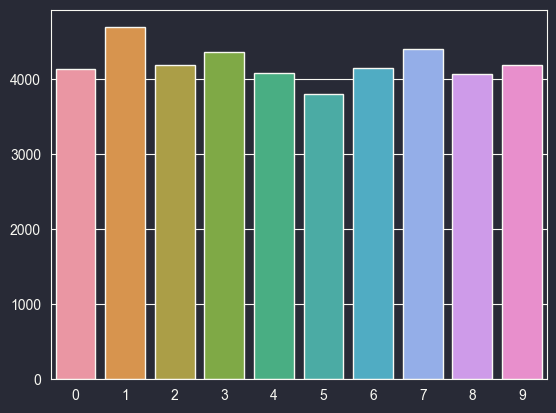

In [5]:
df = pd.read_csv("train.csv")

sns.barplot(x=df["label"].value_counts().keys().values, y=df["label"].value_counts().values)

## Define transforms

torchvision has transforms module, which allows to make transformations to data packed in Dataset and Dataloader classes.

Transforms will be applied to each sample of data when picked from torch.utils.data.Dataset.

At first pixel values are in range [0, 255]. We transform it to range [0, 1] and change its type to torch.float32.

For train data we apply Random Rotation: it will rotate image randomly a little to augment training data and create new samples.

Then we normalize data.

In [6]:
ROTATION_ANGLE = 2

label_transforms = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x).to(torch.long)),
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x/255.0).to(torch.float32)),
    transforms.Normalize((0.1307,), (0.3081,)),
])
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x/255.0).to(torch.float32)),
    transforms.RandomRotation(degrees=(-ROTATION_ANGLE, ROTATION_ANGLE)),
    transforms.Normalize((0.1307,), (0.3081,)),
])

## Define custom Dataset

A custom Dataset should have at least 3 magic methods:
    - __init__(*args, **kwargs) - accepts transforms and other params;
    - __len__() - returns size of dataset;
    - __getitem__(idx) - return item with applied transformations to it;

MnistDataset constructor accepts filename, which contains data for training and testing, transforms that will be applied to data, bool parameter, which tells whether dataset is for training or not.

In [7]:
class MnistDataset(Dataset):
    def __init__(self, annotations_file: str, transform: transforms.Compose=None,
                 target_transform: transforms.Compose=None, train: bool=False):
        df = pd.read_csv(annotations_file)
        self.img_pixels = df.loc[:, df.columns!="label"].values.reshape(df.__len__(), 28, 28)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        self.img_labels = df["label"].astype("long").values if self.train else None

    def __len__(self):
        return len(self.img_pixels)

    def __getitem__(self, idx):
        image = self.img_pixels[idx]
        if self.transform:
            image = self.transform(image)
        if self.train:
            label = self.img_labels[idx]
            if self.target_transform:
                label = self.target_transform(label)
            return image, label
        else:
            return image

## Create Dataloaders

After defining Dataset we can create Dataloader, which accepts our MnistDataset, batch_size, shuffle.
    - batch_size - describes, how big will be batch of data, when iterating over dataloader; the bigger the size of batch, the more data will be loaded into RAM;
    - shuffle - bool param, which tells, whether the data should be shuffled when iterating over dataloader;

It's worth shuffling train_loader for network robustness to new data;



In [72]:
mnist_train_dataset = MnistDataset("train.csv", transform=train_transforms, target_transform=label_transforms, train=True)
mnist_test_dataset = MnistDataset("test.csv", transform=test_transforms, train=False)

mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=128, shuffle=False)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=128, shuffle=False)

# Network

MNIST dataset is a kind of "Hello world!" in CV. The best kind of network for such data is convolutional. Let's define Convolutional Neural Network (CNN):
<ol>
    <li>At first it has 2 Convolutional layers with ReLU activation function.</li>
    <li>Maxpooling is applied to the output with kernel size == 2: from a square of 4 pixels the one with the highest value is picked.</li>
    <li>Dropout is used to reduce overfitting.</li>
    <li>Then the data is flattened and passed to Linear layers.</li>
    <li>Finally LogSoftmax is applied to get probabilities for numbers.</li>
</ol>

Sequential() - takes sequence of nn.Modules and passes data through them in the order the layers are written into it when defining.

In [85]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(9216, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, input):
        output = self.layers(input)
        return output

# Function for training

Now we define train function, which accepts:
<ul>
    <li>Main parameters: network, loader, loss function, optimizer</li>
    <li>Hyperparameters: learning rate, epoch number</li>
    <li>Other parameters: whether to use GPU, to plot and to verbose</li>
</ul>

After creating necessary variables and switching network to train we begin.

During one epoch we iterate over dataloader to get data and labels.
In one iteration we zero gradients, make prediction, calculate loss, do backprop, and make optimization step. Moreover we save accuracies and losses to plot it if we want.

After that we write additional output and draw accuracies/losses plots if we want to examine process of learning.

In [86]:
def train(network: nn.Module, train_loader: DataLoader,
          loss: nn.modules.loss = None, optim: torch.optim = None,
          learning_rate: float = 0.01, epochs: int =10, gpu: bool = False,
          plot: bool = False, verbose: bool = False):
    loss = loss or nn.NLLLoss()
    optimizer = optim or torch.optim.Adam(network.parameters(), lr=learning_rate)

    train_losses = []
    train_accuracies = []
    train_preds = []

    network.to(device=gpu_device) if gpu else network.to(device=cpu_device)
    network.train()
    for i in tqdm(range(epochs)):
        accuracies = []
        losses = []
        preds = []
        for batch_x, batch_y in train_loader:
            if gpu:
                batch_x = batch_x.to(device=gpu_device)
                batch_y = batch_y.to(device=gpu_device)
            optimizer.zero_grad()
            pred = network(batch_x)
            batch_loss = loss(pred, batch_y)
            losses.append(batch_loss.item())
            batch_loss.backward()
            optimizer.step()

            accuracies.append((np.argmax(pred.cpu().data.numpy(), axis=1) == batch_y.cpu().data.numpy()).mean())
            preds.append(pred)
        train_losses.append(np.mean(losses))
        train_accuracies.append(np.mean(accuracies))
        train_preds.append(preds)
        if verbose:
            clear_output(True)
            sys.stdout.write(f"Epoch {i}: Train loss/accuracy: {train_losses[i]:.3f}/{train_accuracies[i]:.3f}")
        if plot:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.xlabel("Epoch")
            plt.ylabel("Losses")
            plt.plot(train_losses)
            plt.grid("on")
            plt.subplot(1, 2, 2)
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.plot(train_accuracies)
            plt.grid("on")
            plt.show()
    return train_accuracies, train_losses, train_preds

# Evaluation

Not it's time to create our network and train.

Epoch 19: Train loss/accuracy: 0.004/0.999

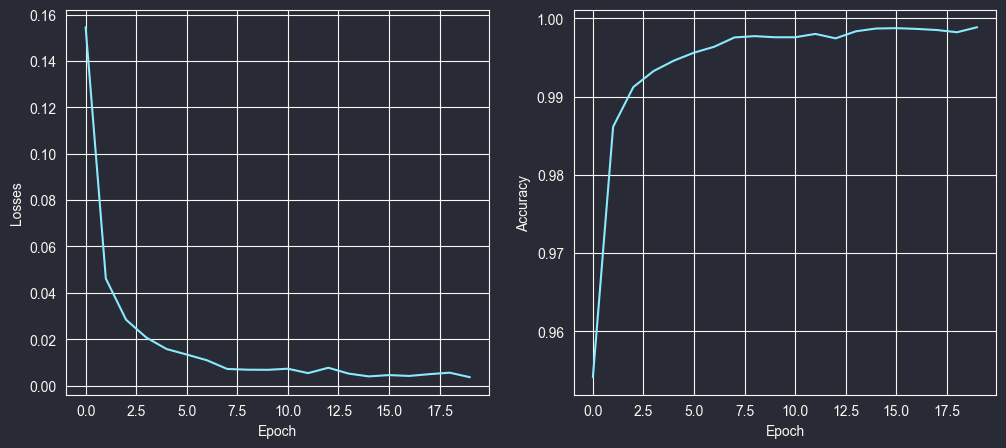

100%|██████████| 20/20 [02:23<00:00,  7.16s/it]


In [87]:
cnn = CNN()
tr_ac, tr_ls, predictions = train(cnn, mnist_train_loader, learning_rate=0.001,
                                  epochs=20, loss=nn.CrossEntropyLoss(), gpu=True,
                                  verbose=True, plot=True)

Let's see incorrect labels.

/var/folders/3h/dhhfcbhd3pl2ss8czvd22c080000gn/T/ipykernel_90269/1719302355.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,5,count)


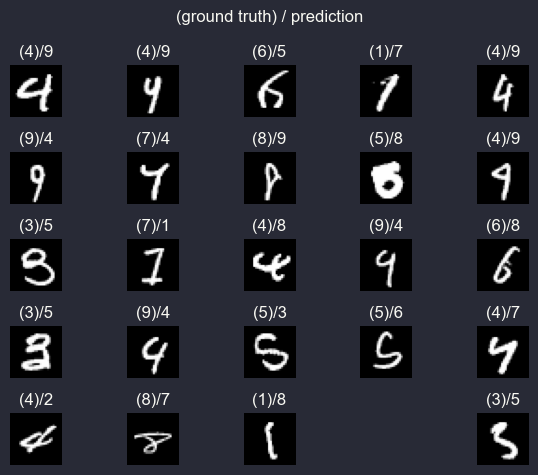

In [88]:
count = 1
plt.suptitle("(ground truth) / prediction")
for idx, (X, y) in enumerate(mnist_train_loader):
    if count > 25:
        break
    for i in range(128):
        if count <= 25 and y[i].item() != predictions[-1][idx][i].argmax().item():
            plt.subplot(5,5,count)
            plt.imshow(X[i][0], cmap=plt.cm.Greys_r)
            plt.title(f"({y[i].item()})/{predictions[-1][idx][i].argmax().item()}")
            plt.axis("off")
            plt.tight_layout()
            count += 1

# Test prediction

Now let's make prediction for kaggle test dataset. We switch network mode to evaluation, disable gradient computation and make predictions.

In [89]:
def test(network: nn.Module, test_loader: DataLoader, gpu: bool = False):
    network.to(device=gpu_device) if gpu else network.to(device=cpu_device)
    network.eval()
    predictions = []
    with torch.no_grad():
        for X in tqdm(test_loader):
            if gpu:
                X = X.to(device=gpu_device)
            preds = network(X)
            predictions.append(preds)

    return predictions

In [90]:
predictions = test(cnn, mnist_test_loader, gpu=True)

100%|██████████| 219/219 [00:00<00:00, 272.79it/s]


Finally we prepare dataset and save it into .csv file.

In [92]:
submission = []
i = 1
for pred_batch in tqdm(predictions):
    for probs in pred_batch:
        submission.append([i, probs.argmax().item()])
        i += 1
result = pd.DataFrame(submission, columns=["ImageID", "Label"])
result.to_csv("submission.csv", index=False)

100%|██████████| 219/219 [00:05<00:00, 40.43it/s]
